In [1]:
%cd "~/code/snet/moses-incons-pen-xp"
%load_ext autoreload
%autoreload

/home/xabush/code/snet/moses-incons-pen-xp


In [2]:
%matplotlib inline

In [3]:
import numpy as np
import numpy.random as rng
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import daft
import arviz as az
import theano
import theano.tensor as tt
import scipy
import scipy.stats as st
from sklearn.metrics import mutual_info_score
from sklearn.model_selection import train_test_split


In [4]:
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
sns_c

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [17]:
### Python version of Jonathan's code to generate synth network
def gen_synth_net(num_feats, p=0.3):
    J = np.zeros((num_feats, num_feats))
    for i in range(num_feats):
        for j in range(i+1, num_feats):
            u = np.random.uniform()
            if u < p:
                r = st.halfnorm().rvs()
                # r = 1
                J[i, j] = r
                J[j, i] = r

    return J

def rank_by_mi(feats, df, seed):
    mi_scores = []
    X, y = df[df.columns.difference(["y"])], df["y"]
    X_train, _, y_train, _ = train_test_split(X, y, stratify=y, shuffle=True, random_state=seed)
    X_train = X_train.to_numpy()
    for s in feats:
        s_score = 0.0
        for f in s:
            mi = mutual_info_score(y_train, X_train[:,f])
            s_score += mi

        mi_scores.append(s_score / len(s))

    return np.argsort(np.array(mi_scores))[::-1], np.sort(np.array(mi_scores))[::-1]

In [6]:
from notebooks.manifold_reg.util import load_bmm_files
seeds, data_dfs, net_dfs, feats = load_bmm_files("data/bmm_data_thr_2/")
seed_idx = 5
# J = net_dfs[seed_idx].to_numpy()
J = np.abs(net_dfs[seed_idx].to_numpy())
J[J > 0.0] = 1.0
L = scipy.sparse.csgraph.laplacian(J, normed=True)

### Model
#### $\mathit{p}(\mathbf{\boldsymbol{\gamma}}) = \frac{1}{\textbf{Z}_p}e^{-\beta E(\gamma)}$,
where $E(\gamma) = \boldsymbol{\mu}\textbf{1}_p\boldsymbol{\gamma}  +  \eta\boldsymbol{\gamma^T}\mathbf{L}\boldsymbol{\gamma}$

#### $\mathit{p}(\mathbf{\boldsymbol{\gamma}}) = \frac{1}{\textbf{Z}_p}e^{-\beta(\boldsymbol{\mu}\textbf{1}_p\boldsymbol{\gamma}   +   \eta\boldsymbol{\gamma^T}\mathbf{L}\boldsymbol{\gamma})$
where $\gamma$ - binary variables, $L$ - Graph Laplacian, $\mu$ - sparsity coefficient, $\eta$ - smoothing coefficient, $\beta = \frac{1}{kT}$

In [7]:
import numpy as np
import numba

@numba.njit(nogil=True)
def ising_energy(gamma, G, mu=1.0, eta=1.0):
    d1 = np.dot(gamma, G)
    E = np.dot(d1, gamma)
    # E = 0.0
    # for i in range(gamma.shape[0]):
    #     for j in range(i+1, gamma.shape[0]):
    #         if G[i, j] != 0:
    #             E += G[i, j] * gamma[i] * gamma[j]

    # s = 0.0
    # for i in range(gamma):
    #     s += i


    return eta*E + mu*np.sum(gamma)

@numba.njit(nogil=True)
def metropolis(J, times, B=1.0, c=5, n=100, mu=1.0, eta=1.0):
    net_spins = np.zeros((c, times))
    net_energy = np.zeros((c, times))
    N = J.shape[0]
    samples = np.zeros((n, N))
    for j in range(c):
        init_state = np.random.randint(0, 2, size=N)
        init_state = init_state.astype(np.float_)
        energy = ising_energy(init_state, J, mu, eta)
        curr_st = init_state.copy()
        for t in range(0,times):
            # 2. pick random point on array and flip spin
            i = np.random.randint(0, N)
            prev_st = curr_st.copy()
            E_prev = ising_energy(prev_st, J, mu=mu, eta=eta)
            val = np.abs(curr_st[i] - 1) # flip the current position
            # val = prev_st[i]*-1
            prev_st[i] = val
            # compute change in energy
            E_curr = ising_energy(prev_st, J, mu=mu, eta=eta)
            # 3 / 4. change state with designated probabilities
            dE = E_curr-E_prev
            prob = np.exp(-B*dE)

            if (dE>0)*(np.random.random() < prob): ## accept the move lower probability state with probability p
                curr_st[i] = val
                energy += dE
            elif dE<=0: ##accept the move to higher probability state
                curr_st[i] = val
                energy += dE

            net_spins[j, t] = curr_st.sum()
            net_energy[j, t] = energy
            if times - t <= n:
                samples[n - (times - t)] = curr_st

    return net_spins, net_energy, samples

In [8]:

net_spins, net_energy, samples = metropolis(L, int(1e6), B=1.0, n=10000)

In [9]:
energy_vals = [ising_energy(samples[i], L) for i in range(samples.shape[0])]
prob_vals = [np.exp(-e) for e in energy_vals]

[Text(0.5, 1.0, 'Probability for 1000 samples'),
 Text(0.5, 0, 'i'),
 Text(0, 0.5, '$p(\\gamma)$')]

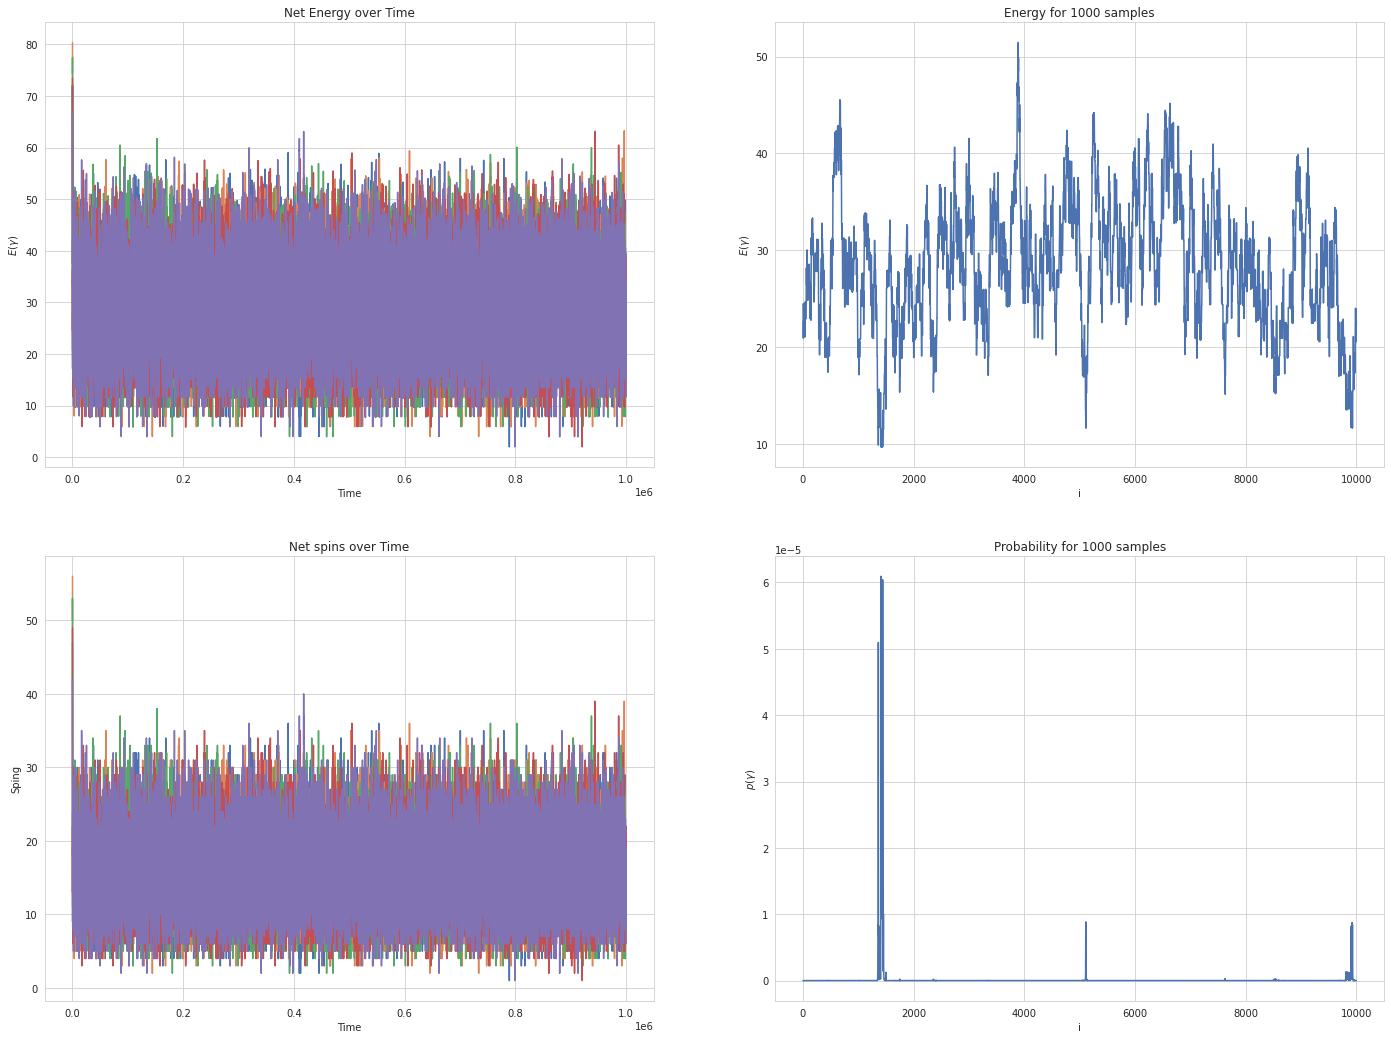

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(24, 18))
s = np.arange(1, net_energy.shape[1] + 1)
t = np.arange(1, samples.shape[0] + 1)
for i in range(net_energy.shape[0]):
    ax[0, 0].plot(s, net_energy[i])
    ax[1, 0].plot(s, net_spins[i])

ax[0, 1].plot(t, energy_vals)
ax[1, 1].plot(t, prob_vals)

ax[0, 0].set(title="Net Energy over Time", xlabel="Time", ylabel="$E(\gamma)$")
ax[1, 0].set(title="Net spins over Time", xlabel="Time", ylabel="Sping")
ax[0, 1].set(title="Energy for 1000 samples", xlabel="i", ylabel="$E(\gamma)$")
ax[1, 1].set(title="Probability for 1000 samples", xlabel="i", ylabel="$p(\gamma)$")

In [11]:
idx = np.argsort(prob_vals)[::-1]

4.050103339751066e-08


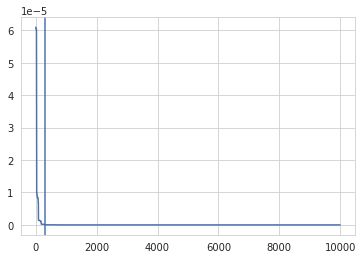

In [12]:
m = 300
print(prob_vals[idx[m]])
plt.plot(t, np.sort(prob_vals)[::-1])
plt.axvline(x=m)

In [13]:

feats_high_prob = []
prob_vals_feats = []
for i, arr in enumerate(samples):
    lst = list(np.nonzero(arr)[0])
    if not lst in feats_high_prob and prob_vals[i] > 0.0:
        feats_high_prob.append(lst)
        prob_vals_feats.append(prob_vals[i])

feats_high_prob

[[7, 8, 21, 48, 49, 56, 57, 62, 63, 67, 74, 85, 96],
 [7, 8, 21, 49, 56, 57, 62, 63, 67, 74, 85, 96],
 [7, 8, 21, 56, 57, 62, 63, 67, 74, 85, 96],
 [7, 8, 21, 56, 57, 62, 63, 67, 72, 74, 85, 96],
 [7, 8, 21, 49, 56, 57, 62, 63, 67, 72, 74, 85, 96],
 [7, 21, 49, 56, 57, 62, 63, 67, 72, 74, 85, 96],
 [7, 21, 49, 56, 57, 62, 63, 67, 72, 74, 85],
 [7, 21, 29, 49, 56, 57, 62, 63, 67, 72, 74, 85],
 [7, 21, 29, 49, 56, 57, 62, 63, 67, 72, 74, 85, 87],
 [7, 21, 29, 56, 57, 62, 63, 67, 72, 74, 85, 87],
 [7, 21, 29, 50, 56, 57, 62, 63, 67, 72, 74, 85, 87],
 [7, 21, 29, 50, 56, 57, 62, 63, 66, 67, 72, 74, 85, 87],
 [7, 11, 21, 29, 50, 56, 57, 62, 63, 66, 67, 72, 74, 85, 87],
 [7, 11, 21, 29, 50, 56, 57, 62, 63, 66, 72, 74, 85, 87],
 [7, 11, 21, 29, 50, 56, 57, 62, 63, 66, 72, 74, 82, 85, 87],
 [7, 11, 21, 29, 33, 50, 56, 57, 62, 63, 66, 72, 74, 82, 85, 87],
 [11, 21, 29, 33, 50, 56, 57, 62, 63, 66, 72, 74, 82, 85, 87],
 [21, 29, 33, 50, 56, 57, 62, 63, 66, 72, 74, 82, 85, 87],
 [21, 29, 33, 56, 5

In [14]:
len(feats_high_prob)

3091

In [26]:
mi_idxs, mi_scores = rank_by_mi(feats_high_prob, data_dfs[seed_idx], seeds[seed_idx])
feats_mi_rank = [feats_high_prob[i] for i in mi_idxs][:100]
mi_scores

array([0.0040497 , 0.00402563, 0.00400483, ..., 0.00028174, 0.00027976,
       0.00023819])

In [27]:
feats_mi_rank

[[0, 13, 16, 32, 44, 45, 52, 66, 67, 75, 89, 93, 94, 96],
 [0, 16, 32, 44, 45, 52, 66, 75, 81, 89, 93, 94, 96],
 [0, 16, 32, 44, 45, 52, 66, 67, 75, 81, 89, 93, 94, 96],
 [26, 37, 38, 45, 46, 51, 67, 68, 73, 94, 99],
 [26, 37, 38, 45, 46, 51, 62, 67, 68, 73, 94, 99],
 [0, 13, 16, 32, 42, 44, 45, 52, 66, 67, 75, 89, 93, 94, 96],
 [0, 13, 16, 32, 44, 45, 52, 66, 67, 75, 81, 89, 93, 94, 96],
 [26, 33, 37, 38, 45, 46, 51, 68, 73, 94],
 [16, 26, 33, 37, 38, 45, 46, 51, 68, 70, 73, 94],
 [26, 33, 37, 38, 45, 46, 51, 68, 73, 94, 99],
 [21, 32, 42, 45, 53, 56, 57, 67, 68, 82, 83, 99],
 [26, 28, 37, 38, 45, 46, 51, 67, 68, 73, 94, 99],
 [26, 33, 37, 38, 45, 46, 51, 62, 67, 68, 73, 94, 99],
 [26, 33, 37, 38, 45, 46, 51, 62, 68, 73, 94, 99],
 [0, 13, 16, 32, 42, 44, 45, 52, 66, 67, 75, 81, 89, 93, 94, 96],
 [16, 26, 33, 37, 38, 45, 46, 51, 63, 68, 70, 73, 94],
 [31, 35, 37, 45, 50, 52, 56, 65, 67, 72, 73, 74, 94],
 [16, 26, 32, 33, 37, 38, 45, 46, 51, 63, 65, 68, 70, 73, 94],
 [16, 26, 33, 37, 38

In [29]:
from notebooks.manifold_reg.MosesEstimator import run_fs_moses
from sklearn.model_selection import cross_val_score

res_auc_mi_best = run_fs_moses(data_dfs[seed_idx], seeds[seed_idx], feats_mi_rank)
res_auc_mi_best

{'moses_cv_score': 0.5980854071332287, 'moses_test_score': 0.6002325195150308, 'log_cv_score': 0.5, 'log_test_score': 0.5185185185185186}
{'moses_cv_score': 0.5919937780064537, 'moses_test_score': 0.574987543597409, 'log_cv_score': 0.5, 'log_test_score': 0.5185185185185186}
{'moses_cv_score': 0.595544801338672, 'moses_test_score': 0.6002325195150308, 'log_cv_score': 0.5, 'log_test_score': 0.5185185185185186}
{'moses_cv_score': 0.4880121322236116, 'moses_test_score': 0.5677628300946687, 'log_cv_score': 0.4992481203007519, 'log_test_score': 0.5}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

{'moses_cv_score': 0.47820733306137164, 'moses_test_score': 0.5490782262082711, 'log_cv_score': 0.4992481203007519, 'log_test_score': 0.5}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

{'moses_cv_score': 0.5961989143520366, 'moses_test_score': 0.6041355256601892, 'log_cv_score': 0.5, 'log_test_score': 0.5185185185185186}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'moses_cv_score': 0.6002726480121672, 'moses_test_score': 0.597990367048663, 'log_cv_score': 0.5, 'log_test_score': 0.5185185185185186}
{'moses_cv_score': 0.5053135481634987, 'moses_test_score': 0.520428500249128, 'log_cv_score': 0.49925373134328355, 'log_test_score': 0.5}
{'moses_cv_score': 0.42824935494889943, 'moses_test_score': 0.5411891712340142, 'log_cv_score': 0.49925373134328355, 'log_test_score': 0.5}
{'moses_cv_score': 0.5145163010176179, 'moses_test_score': 0.5344627138349112, 'log_cv_score': 0.49925373134328355, 'log_test_score': 0.5}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'moses_cv_score': 0.5555323133795202, 'moses_test_score': 0.5312240491612689, 'log_cv_score': 0.4992481203007519, 'log_test_score': 0.5}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

{'moses_cv_score': 0.4839889097505427, 'moses_test_score': 0.558212921441621, 'log_cv_score': 0.4992481203007519, 'log_test_score': 0.5}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

{'moses_cv_score': 0.4576828727590086, 'moses_test_score': 0.5335492443115761, 'log_cv_score': 0.4992481203007519, 'log_test_score': 0.5}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'moses_cv_score': 0.45437966292539933, 'moses_test_score': 0.5215080551403422, 'log_cv_score': 0.5, 'log_test_score': 0.5}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

{'moses_cv_score': 0.5973391384765122, 'moses_test_score': 0.5811327022089353, 'log_cv_score': 0.5, 'log_test_score': 0.5185185185185186}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

{'moses_cv_score': 0.43520080074280576, 'moses_test_score': 0.5553894701876765, 'log_cv_score': 0.49925373134328355, 'log_test_score': 0.5}
{'moses_cv_score': 0.578324163403866, 'moses_test_score': 0.48173060953330016, 'log_cv_score': 0.5, 'log_test_score': 0.5185185185185186}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

{'moses_cv_score': 0.5313703691562559, 'moses_test_score': 0.5725793057631623, 'log_cv_score': 0.49925373134328355, 'log_test_score': 0.5}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

{'moses_cv_score': 0.4630410967718913, 'moses_test_score': 0.5086364391297127, 'log_cv_score': 0.49925373134328355, 'log_test_score': 0.5}
{'moses_cv_score': 0.5341086948121627, 'moses_test_score': 0.5468360737419034, 'log_cv_score': 0.5, 'log_test_score': 0.5185185185185186}
{'moses_cv_score': 0.5418767582884956, 'moses_test_score': 0.4688589935226707, 'log_cv_score': 0.4992481203007519, 'log_test_score': 0.5}
{'moses_cv_score': 0.4700797904813214, 'moses_test_score': 0.5097990367048664, 'log_cv_score': 0.49925373134328355, 'log_test_score': 0.5}
{'moses_cv_score': 0.5362499051802991, 'moses_test_score': 0.5463378176382662, 'log_cv_score': 0.4992481203007519, 'log_test_score': 0.5}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'moses_cv_score': 0.5490543127774251, 'moses_test_score': 0.5053147317721309, 'log_cv_score': 0.5, 'log_test_score': 0.5185185185185186}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

{'moses_cv_score': 0.5589065855310917, 'moses_test_score': 0.5665171898355755, 'log_cv_score': 0.5054981203007519, 'log_test_score': 0.5}
{'moses_cv_score': 0.5435040421169975, 'moses_test_score': 0.5070586281348612, 'log_cv_score': 0.4992481203007519, 'log_test_score': 0.5}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

{'moses_cv_score': 0.5571870965048917, 'moses_test_score': 0.5524829762497924, 'log_cv_score': 0.5054981203007519, 'log_test_score': 0.5}
{'moses_cv_score': 0.5489725754899427, 'moses_test_score': 0.5367879089852184, 'log_cv_score': 0.5054981203007519, 'log_test_score': 0.5}
{'moses_cv_score': 0.5144686792910289, 'moses_test_score': 0.5468360737419034, 'log_cv_score': 0.4992481203007519, 'log_test_score': 0.5}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'moses_cv_score': 0.507936261880374, 'moses_test_score': 0.5692575984055804, 'log_cv_score': 0.49925373134328355, 'log_test_score': 0.5}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

{'moses_cv_score': 0.48963144129957126, 'moses_test_score': 0.5462547749543265, 'log_cv_score': 0.4992481203007519, 'log_test_score': 0.5}
{'moses_cv_score': 0.5608358194966514, 'moses_test_score': 0.46711509715994026, 'log_cv_score': 0.5, 'log_test_score': 0.5185185185185186}
{'moses_cv_score': 0.6052669201632107, 'moses_test_score': 0.4706028898854011, 'log_cv_score': 0.49849624060150377, 'log_test_score': 0.5}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

{'moses_cv_score': 0.5187394608265439, 'moses_test_score': 0.5636106958976914, 'log_cv_score': 0.4985018516440355, 'log_test_score': 0.5}
{'moses_cv_score': 0.5783693404053918, 'moses_test_score': 0.46711509715994026, 'log_cv_score': 0.5, 'log_test_score': 0.5185185185185186}
{'moses_cv_score': 0.533839032993719, 'moses_test_score': 0.48854010961634275, 'log_cv_score': 0.5054981203007519, 'log_test_score': 0.5}
{'moses_cv_score': 0.5916787688805358, 'moses_test_score': 0.6126058794220229, 'log_cv_score': 0.5, 'log_test_score': 0.5185185185185186}
{'moses_cv_score': 0.5717928974224245, 'moses_test_score': 0.5935060621159276, 'log_cv_score': 0.5, 'log_test_score': 0.5185185185185186}
{'moses_cv_score': 0.5079415521862295, 'moses_test_score': 0.5974090682610862, 'log_cv_score': 0.50625, 'log_test_score': 0.5}
{'moses_cv_score': 0.514491414508288, 'moses_test_score': 0.5199302441454908, 'log_cv_score': 0.5, 'log_test_score': 0.5185185185185186}
{'moses_cv_score': 0.524088548694014, 'moses_

/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

{'moses_cv_score': 0.4977324270391105, 'moses_test_score': 0.4711011459890383, 'log_cv_score': 0.4985018516440355, 'log_test_score': 0.4977578475336323}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

{'moses_cv_score': 0.5367652748665424, 'moses_test_score': 0.5832918119913635, 'log_cv_score': 0.49925373134328355, 'log_test_score': 0.5}
{'moses_cv_score': 0.531137838323555, 'moses_test_score': 0.6254774954326524, 'log_cv_score': 0.4992481203007519, 'log_test_score': 0.4977578475336323}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

{'moses_cv_score': 0.5286260951972376, 'moses_test_score': 0.4598903836571998, 'log_cv_score': 0.4992481203007519, 'log_test_score': 0.5}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'moses_cv_score': 0.5493773301100177, 'moses_test_score': 0.5642750373692078, 'log_cv_score': 0.5054981203007519, 'log_test_score': 0.4977578475336323}
{'moses_cv_score': 0.4934324393861268, 'moses_test_score': 0.6253944527487129, 'log_cv_score': 0.50625, 'log_test_score': 0.5}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'moses_cv_score': 0.5593612617008963, 'moses_test_score': 0.5435143663843216, 'log_cv_score': 0.5054981203007519, 'log_test_score': 0.5}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

{'moses_cv_score': 0.5650096529358766, 'moses_test_score': 0.5732436472346787, 'log_cv_score': 0.5054981203007519, 'log_test_score': 0.5}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

{'moses_cv_score': 0.5455823220287663, 'moses_test_score': 0.4733432984554061, 'log_cv_score': 0.5054981203007519, 'log_test_score': 0.4977578475336323}
{'moses_cv_score': 0.5503730924941965, 'moses_test_score': 0.5103803354924432, 'log_cv_score': 0.5054981203007519, 'log_test_score': 0.5}
{'moses_cv_score': 0.5384891248071669, 'moses_test_score': 0.5799701046337818, 'log_cv_score': 0.4992481203007519, 'log_test_score': 0.5}
{'moses_cv_score': 0.5168228198674314, 'moses_test_score': 0.5105464208603222, 'log_cv_score': 0.4992481203007519, 'log_test_score': 0.5}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

{'moses_cv_score': 0.5781508055411975, 'moses_test_score': 0.45756518850689254, 'log_cv_score': 0.5, 'log_test_score': 0.5185185185185186}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

{'moses_cv_score': 0.4743006744194738, 'moses_test_score': 0.5236671649227703, 'log_cv_score': 0.4992481203007519, 'log_test_score': 0.5}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

{'moses_cv_score': 0.5473961876040179, 'moses_test_score': 0.48173060953330016, 'log_cv_score': 0.5, 'log_test_score': 0.5185185185185186}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'moses_cv_score': 0.5416990015703251, 'moses_test_score': 0.5188506892542767, 'log_cv_score': 0.5054981203007519, 'log_test_score': 0.5}
{'moses_cv_score': 0.5723325338917415, 'moses_test_score': 0.5602889885401096, 'log_cv_score': 0.4992481203007519, 'log_test_score': 0.5}
{'moses_cv_score': 0.5574812889783533, 'moses_test_score': 0.40267397442285335, 'log_cv_score': 0.5, 'log_test_score': 0.5}
{'moses_cv_score': 0.6015136278014899, 'moses_test_score': 0.47508719481813655, 'log_cv_score': 0.4992481203007519, 'log_test_score': 0.5}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

{'moses_cv_score': 0.5723638796880127, 'moses_test_score': 0.5491612688922106, 'log_cv_score': 0.5, 'log_test_score': 0.5185185185185186}
{'moses_cv_score': 0.5165668578131538, 'moses_test_score': 0.5491612688922106, 'log_cv_score': 0.5, 'log_test_score': 0.5}
{'moses_cv_score': 0.5450611433326534, 'moses_test_score': 0.5434313237003819, 'log_cv_score': 0.5054981203007519, 'log_test_score': 0.5}
{'moses_cv_score': 0.5889152634142757, 'moses_test_score': 0.4706028898854011, 'log_cv_score': 0.49849624060150377, 'log_test_score': 0.5}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

{'moses_cv_score': 0.4896838765281478, 'moses_test_score': 0.5580468360737418, 'log_cv_score': 0.4992481203007519, 'log_test_score': 0.5}
{'moses_cv_score': 0.5839016577439811, 'moses_test_score': 0.5552233848197974, 'log_cv_score': 0.4992481203007519, 'log_test_score': 0.5}
{'moses_cv_score': 0.5282298972468529, 'moses_test_score': 0.46055472512871615, 'log_cv_score': 0.5, 'log_test_score': 0.5}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

{'moses_cv_score': 0.550422925492751, 'moses_test_score': 0.5412722139179538, 'log_cv_score': 0.4992481203007519, 'log_test_score': 0.5}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

{'moses_cv_score': 0.4623263426337669, 'moses_test_score': 0.6382660687593423, 'log_cv_score': 0.5, 'log_test_score': 0.5}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'moses_cv_score': 0.4774588056898472, 'moses_test_score': 0.6096993854841388, 'log_cv_score': 0.50625, 'log_test_score': 0.5}
{'moses_cv_score': 0.580031076711553, 'moses_test_score': 0.6075402757017107, 'log_cv_score': 0.5, 'log_test_score': 0.5185185185185186}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'moses_cv_score': 0.46534802828865596, 'moses_test_score': 0.5603720312240492, 'log_cv_score': 0.5, 'log_test_score': 0.5}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'moses_cv_score': 0.471108811617893, 'moses_test_score': 0.602391629297459, 'log_cv_score': 0.50625, 'log_test_score': 0.5}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

{'moses_cv_score': 0.5434486916940002, 'moses_test_score': 0.5726623484471018, 'log_cv_score': 0.5054981203007519, 'log_test_score': 0.5}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

{'moses_cv_score': 0.5546222879322089, 'moses_test_score': 0.4464374688589935, 'log_cv_score': 0.5054981203007519, 'log_test_score': 0.4977578475336323}
{'moses_cv_score': 0.5285163765962438, 'moses_test_score': 0.5485799701046338, 'log_cv_score': 0.5054981203007519, 'log_test_score': 0.5}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

{'moses_cv_score': 0.46800442675374077, 'moses_test_score': 0.5148646404251787, 'log_cv_score': 0.5, 'log_test_score': 0.5}
{'moses_cv_score': 0.5235139861104249, 'moses_test_score': 0.48239495100481644, 'log_cv_score': 0.4992481203007519, 'log_test_score': 0.5}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

{'moses_cv_score': 0.5249702002201454, 'moses_test_score': 0.5626141836904168, 'log_cv_score': 0.5, 'log_test_score': 0.5}
{'moses_cv_score': 0.5642528424003402, 'moses_test_score': 0.5574655372861651, 'log_cv_score': 0.4992481203007519, 'log_test_score': 0.5}
{'moses_cv_score': 0.5054445600228633, 'moses_test_score': 0.48563361567845875, 'log_cv_score': 0.5, 'log_test_score': 0.5}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

{'moses_cv_score': 0.5748755743157357, 'moses_test_score': 0.5778109948513537, 'log_cv_score': 0.5, 'log_test_score': 0.5185185185185186}
{'moses_cv_score': 0.5633037373795441, 'moses_test_score': 0.412223883075901, 'log_cv_score': 0.5, 'log_test_score': 0.5}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

{'moses_cv_score': 0.4839444664964584, 'moses_test_score': 0.5428500249128052, 'log_cv_score': 0.4992481203007519, 'log_test_score': 0.5}
{'moses_cv_score': 0.5771298828120875, 'moses_test_score': 0.5861152632453082, 'log_cv_score': 0.4992481203007519, 'log_test_score': 0.5}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

{'moses_cv_score': 0.475849499069566, 'moses_test_score': 0.5305597076897526, 'log_cv_score': 0.5, 'log_test_score': 0.5}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

{'moses_cv_score': 0.5342327285486033, 'moses_test_score': 0.5620328849028401, 'log_cv_score': 0.5054981203007519, 'log_test_score': 0.5}
{'moses_cv_score': 0.5430817283663804, 'moses_test_score': 0.6081215744892874, 'log_cv_score': 0.5, 'log_test_score': 0.5185185185185186}
{'moses_cv_score': 0.6037924468935773, 'moses_test_score': 0.5760670984886231, 'log_cv_score': 0.5, 'log_test_score': 0.5185185185185186}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

{'moses_cv_score': 0.5061992070591994, 'moses_test_score': 0.5198472014615513, 'log_cv_score': 0.5, 'log_test_score': 0.5}
{'moses_cv_score': 0.6057760776743986, 'moses_test_score': 0.40940043182195646, 'log_cv_score': 0.5, 'log_test_score': 0.5}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

{'moses_cv_score': 0.5413204344756144, 'moses_test_score': 0.46777943863145666, 'log_cv_score': 0.4992481203007519, 'log_test_score': 0.5}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'moses_cv_score': 0.5659951651586309, 'moses_test_score': 0.5552233848197974, 'log_cv_score': 0.4992481203007519, 'log_test_score': 0.5}
{'moses_cv_score': 0.4921265788370979, 'moses_test_score': 0.5491612688922106, 'log_cv_score': 0.5, 'log_test_score': 0.5}


KeyboardInterrupt: 

In [25]:
feats_mi_rank_w = [feats_high_prob[i] for i in mi_idxs][-10:]
run_fs_moses(data_dfs[seed_idx], seeds[seed_idx], feats_mi_rank_w)

{'moses_cv_score': 0.5595665789495354, 'moses_test_score': 0.5075568842384985, 'log_cv_score': 0.5, 'log_test_score': 0.5}
{'moses_cv_score': 0.5669116527962006, 'moses_test_score': 0.4587277860820461, 'log_cv_score': 0.4992481203007519, 'log_test_score': 0.5}
{'moses_cv_score': 0.5418139982040608, 'moses_test_score': 0.4783258594917788, 'log_cv_score': 0.4992481203007519, 'log_test_score': 0.5}
{'moses_cv_score': 0.5595665789495354, 'moses_test_score': 0.5075568842384985, 'log_cv_score': 0.5, 'log_test_score': 0.5}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

{'moses_cv_score': 0.49570642148575095, 'moses_test_score': 0.5699219398770968, 'log_cv_score': 0.4985018516440355, 'log_test_score': 0.5}
{'moses_cv_score': 0.5479872087629715, 'moses_test_score': 0.6131041355256601, 'log_cv_score': 0.5, 'log_test_score': 0.5}
{'moses_cv_score': 0.5410019146453244, 'moses_test_score': 0.6131041355256601, 'log_cv_score': 0.5, 'log_test_score': 0.5}
{'moses_cv_score': 0.5603073196902763, 'moses_test_score': 0.5075568842384985, 'log_cv_score': 0.4992481203007519, 'log_test_score': 0.5}


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

{'moses_cv_score': 0.480669961760145, 'moses_test_score': 0.5715827935558877, 'log_cv_score': 0.4985018516440355, 'log_test_score': 0.5}
{'moses_cv_score': 0.5410019146453244, 'moses_test_score': 0.6131041355256601, 'log_cv_score': 0.5, 'log_test_score': 0.5}


,moses_cv_score,moses_test_score,log_cv_score,log_test_score
0,0.559567,0.507557,0.500000,0.5
1,0.566912,0.458728,0.499248,0.5
2,0.541814,0.478326,0.499248,0.5
3,0.559567,0.507557,0.500000,0.5
4,0.495706,0.569922,0.498502,0.5
5,0.547987,0.613104,0.500000,0.5
6,0.541002,0.613104,0.500000,0.5
7,0.560307,0.507557,0.499248,0.5
8,0.480670,0.571583,0.498502,0.5
9,0.541002,0.613104,0.500000,0.5


In [24]:
feats_mi_rank_w

[[7, 25, 27, 48, 56, 71, 72, 87],
 [6, 9, 10, 15, 27, 47, 49, 51, 52, 55, 57, 70, 74, 83],
 [6, 9, 10, 47, 49, 51, 52, 55, 57, 70, 74, 83],
 [25, 27, 56, 71, 72, 87],
 [0, 8, 12, 15, 19, 24, 29, 36, 44, 51, 72, 73, 84, 92, 95],
 [14, 34, 38, 39, 73, 84, 92],
 [14, 34, 38, 39, 92],
 [7, 25, 27, 48, 56, 68, 71, 72, 87],
 [0, 8, 12, 15, 19, 24, 29, 36, 44, 51, 72, 73, 92, 95],
 [14, 34, 38, 39, 73, 92]]